<img src="https://ww2.ufps.edu.co/public/archivos/elementos_corporativos/logoufps.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
HYBRID MODEL BASED ON ARTIFICIAL INTELLIGENCE FOR ENERGY DISPATCH IN A MICROGRID</font>  

<font size='4'> Forecast Regressor Graphs Notebook</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2023<br>
</font>

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.serif'] = ['Times New Roman']
import plotly.express as px

params = {
            'legend.fontsize': 'x-large',
            'axes.labelsize':'xx-large',
            'axes.titlesize':'xx-large',
            'xtick.labelsize':'xx-large',
            'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [2]:
datos = pd.read_csv('./3_Database.csv')
df = pd.DataFrame(datos)
df = df.drop(['index'],axis=1)

df.loc[df['Produccion FV (MW)'] < 0, 'Produccion FV (MW)'] = 0
df.loc[df['Produccion Eolica (MW)'] < 0, 'Produccion Eolica (MW)'] = 0
df.loc[df['Demanda (MW)'] < 0, 'Demanda (MW)'] = 0

reduccion = [0.2,0.2,0.06]

df['Produccion FV (MW)'] = df['Produccion FV (MW)']*reduccion[0]
df['Produccion Eolica (MW)'] = df['Produccion Eolica (MW)']*reduccion[1]
df['Demanda (MW)'] = df['Demanda (MW)']*reduccion[2]

In [3]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d-T%H:%M')
df= df.set_index('Time')
df= df.asfreq('5min')
df= df.sort_index()

In [4]:
df = df.loc['2019-01-01 00:00': '2021-12-31 23:55']
fin_train = '2021-05-25 23:55'
fin_validacion = '2021-09-12 23:55'
data_train = df.loc[: fin_train, :]
data_val   = df.loc[fin_train:fin_validacion, :]
data_test  = df.loc[fin_validacion:, :]

print(f"Fechas train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)}- 80%)")
print(f"Fechas validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)}- 10%)")
print(f"Fechas test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)}- 10%)")

Fechas train      : 2019-01-01 00:00:00 --- 2021-05-25 23:55:00  (n=252288- 80%)
Fechas validacion : 2021-05-25 23:55:00 --- 2021-09-12 23:55:00  (n=31681- 10%)
Fechas test       : 2021-09-12 23:55:00 --- 2021-12-31 23:55:00  (n=31681- 10%)


<b> <font size='5'>PV Production</font>  

In [9]:
#Markers

marker1 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Entrenamiento [80%]", color="rebeccapurple")
marker2 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Validación [10%]", color="blueviolet")
marker3 = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=10, alpha=1.00,label="Prueba [10%]", color="mediumorchid")

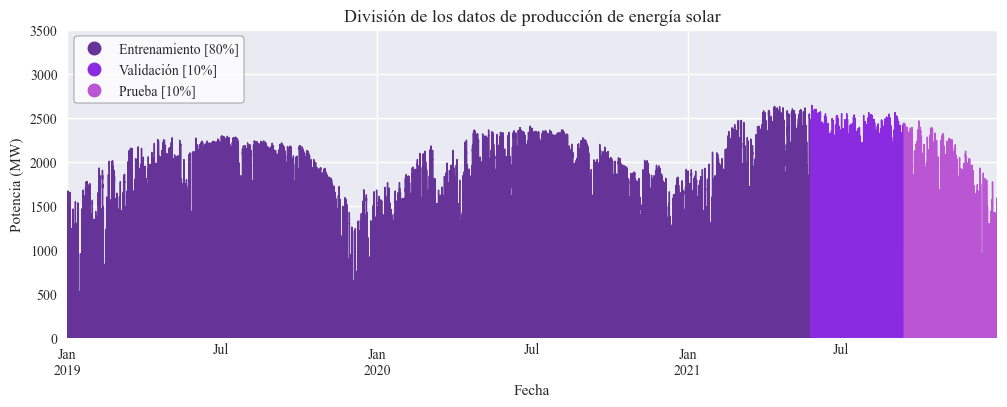

In [13]:
# Visualización de la división de datos 

fig, ax = plt.subplots(figsize=(12, 4))
data_train['Produccion FV (MW)'].plot(ax=ax, label='Train', linewidth=1, color='rebeccapurple')
data_val['Produccion FV (MW)'].plot(ax=ax, label='Validation', linewidth=1, color='blueviolet')
data_test['Produccion FV (MW)'].plot(ax=ax, label='Test', linewidth=1, color='mediumorchid')
ax.set_title('División de los datos de producción de energía solar', size=13)
ax.set_ylim(0,3500)
ax.set_ylabel("Potencia (MW)")
ax.set_xlabel("Fecha")
ax.legend(handles=[marker1,marker2,marker3],frameon=True,loc='upper left',edgecolor='black',facecolor='white')
plt.savefig('./Plots/PV_Data_split.svg',bbox_inches='tight')

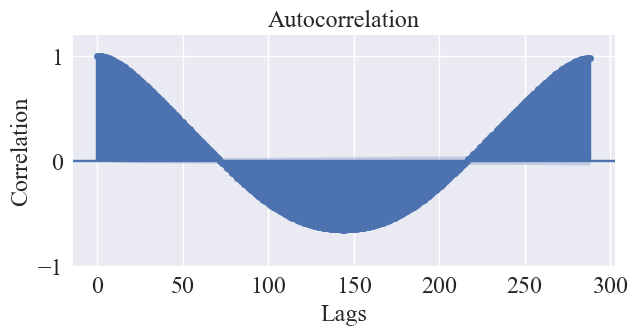

In [6]:
# Autocorrelación 

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Produccion FV (MW)'], ax=ax, lags=288).savefig('./Plots/PV_Data_Autocorrelation.svg',bbox_inches='tight')
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.ylim(-1,1.2)
plt.savefig('./Plots/PV_Data_Autocorrelation.svg',bbox_inches='tight')
plt.show()

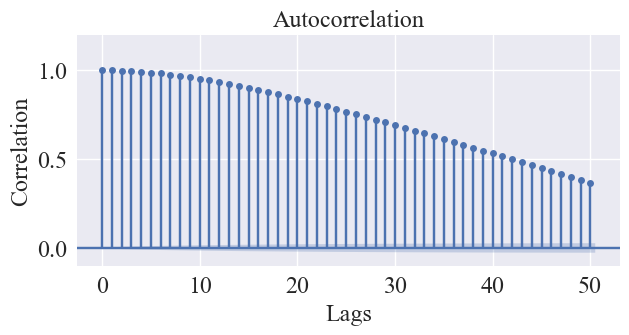

In [7]:
# Autocorrelación with zoom

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Produccion FV (MW)'], ax=ax, lags=50).savefig('./Plots/PV_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.ylim(-0.1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/PV_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.show()

c:\Users\Jarvis\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


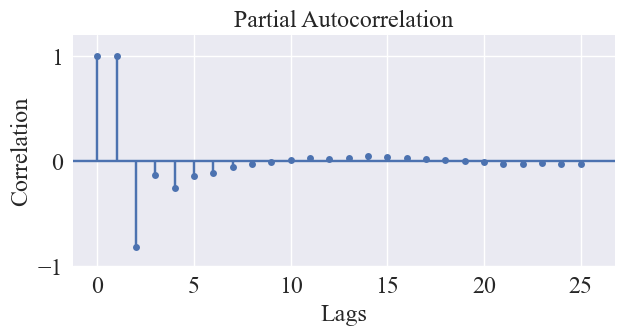

In [8]:
#Autocorrelación Parcial 

fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df['Produccion FV (MW)'], ax=ax, lags=25).savefig('./Plots/PV_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.ylim(-1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/PV_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.show()

C:\Users\Jarvis\AppData\Local\Temp\ipykernel_4268\478777799.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


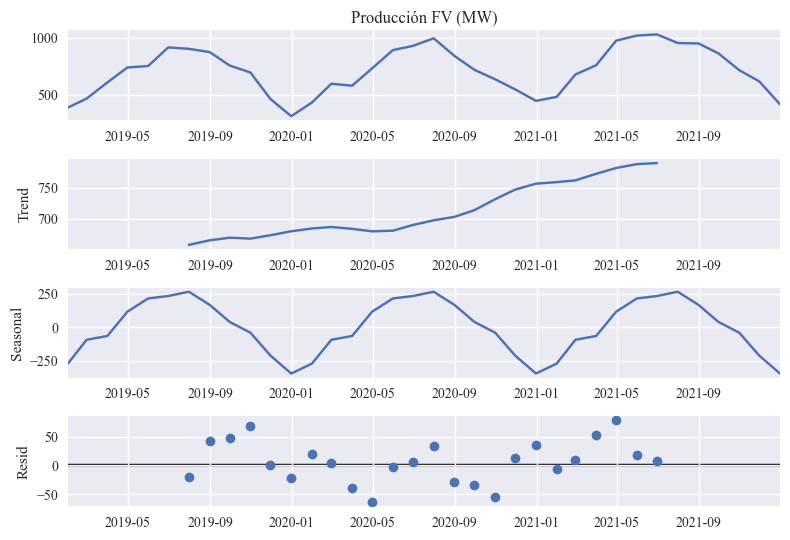

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

datos_ts = df['Produccion FV (MW)'].resample('M').mean()

# Aplicar el método seasonal_decompose a la serie de tiempo
fig=seasonal_decompose(datos_ts, model='additive').plot()
fig.savefig('./Plots/PV_Data_Decomposition.svg',bbox_inches='tight')
fig.show()

<b> <font size='5'>Wind Production</font>  

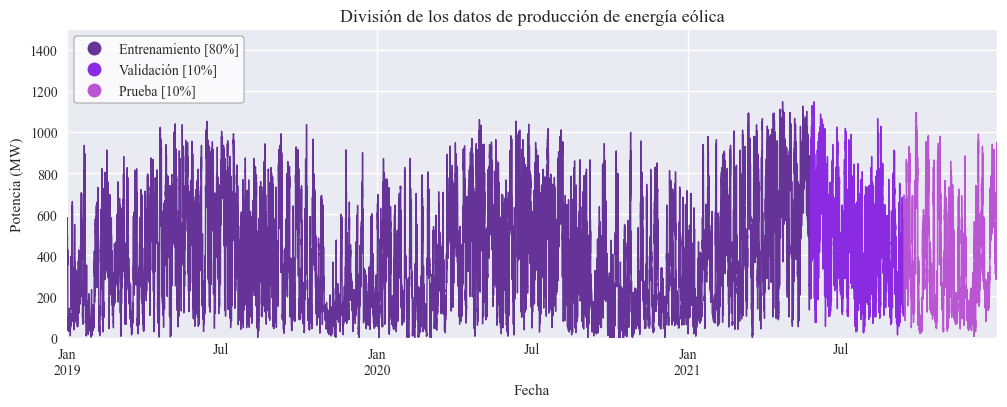

In [14]:
# Visualización de la división de datos 

fig, ax = plt.subplots(figsize=(12, 4))
data_train['Produccion Eolica (MW)'].plot(ax=ax, label='Train', linewidth=1, color='rebeccapurple')
data_val['Produccion Eolica (MW)'].plot(ax=ax, label='Validation', linewidth=1, color='blueviolet')
data_test['Produccion Eolica (MW)'].plot(ax=ax, label='Test', linewidth=1, color='mediumorchid')
ax.set_title('División de los datos de producción de energía eólica', size=13)
ax.set_ylim(0,1500)
ax.set_ylabel("Potencia (MW)")
ax.set_xlabel("Fecha")
ax.legend(handles=[marker1,marker2,marker3],frameon=True,loc='upper left',edgecolor='black',facecolor='white')
plt.savefig('./Plots/Wind_Data_split.svg',bbox_inches='tight')

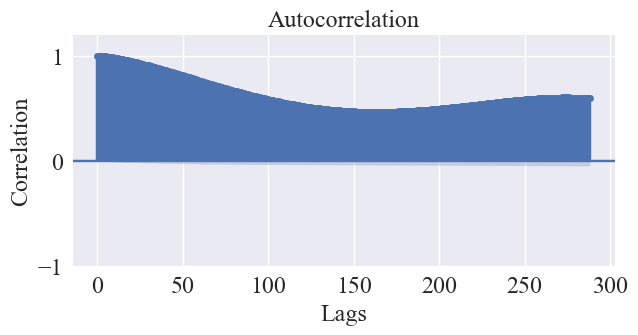

In [9]:
# Autocorrelación (Existe )

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Produccion Eolica (MW)'], ax=ax, lags=288).savefig('./Plots/Wind_Data_Autocorrelation.svg',bbox_inches='tight')
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.ylim(-1,1.2)
plt.savefig('./Plots/Wind_Data_Autocorrelation.svg',bbox_inches='tight')
plt.show()

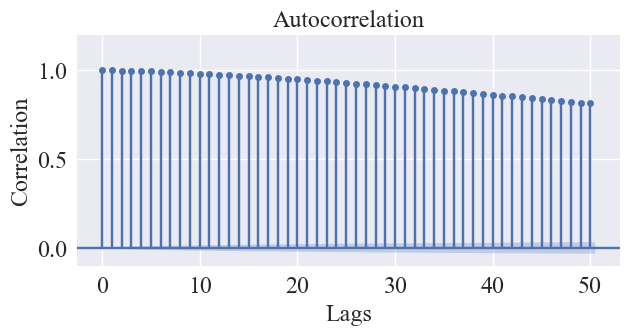

In [10]:
# Autocorrelación with zoom

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Produccion Eolica (MW)'], ax=ax, lags=50).savefig('./Plots/Wind_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.ylim(-0.1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/Wind_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.show()

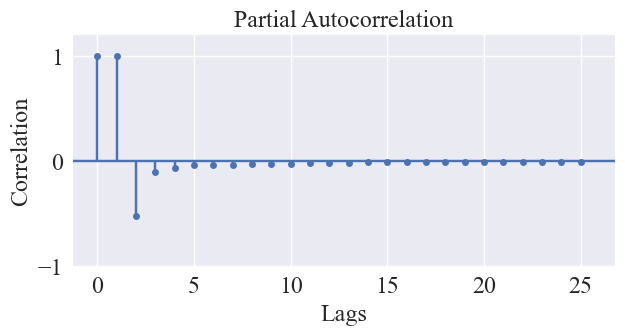

In [11]:
#Autocorrelación Parcial 

fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df['Produccion Eolica (MW)'], ax=ax, lags=25).savefig('./Plots/Wind_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.ylim(-1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/Wind_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.show()

C:\Users\Jarvis\AppData\Local\Temp\ipykernel_4268\1266318720.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


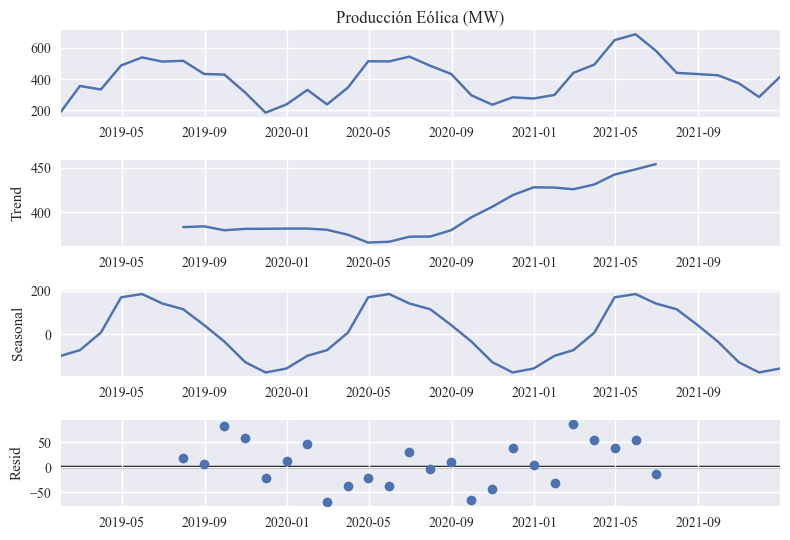

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

datos_ts = df['Produccion Eolica (MW)'].resample('M').mean()

# Aplicar el método seasonal_decompose a la serie de tiempo
fig=seasonal_decompose(datos_ts, model='additive').plot()
fig.savefig('./Plots/Wind_Data_Decomposition.svg',bbox_inches='tight')
fig.show()

<b> <font size='5'>Demand</font>  

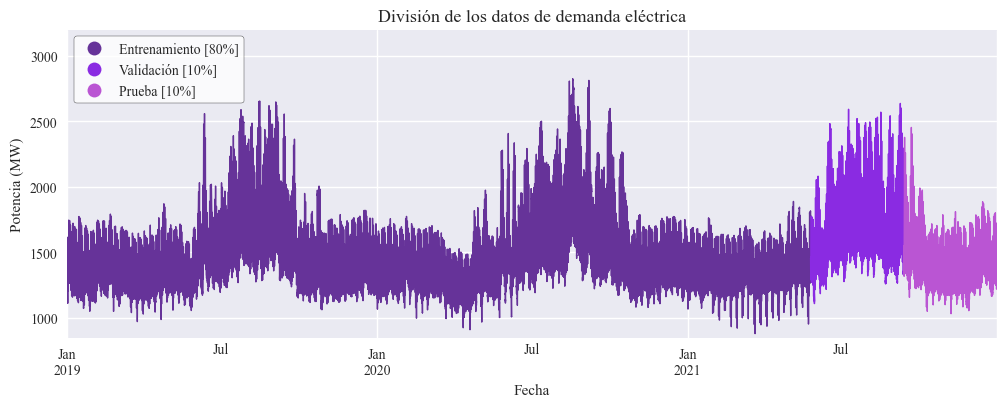

In [15]:
# Visualización de la división de datos 

fig, ax = plt.subplots(figsize=(12, 4))
data_train['Demanda (MW)'].plot(ax=ax, label='Train', linewidth=1, color='rebeccapurple')
data_val['Demanda (MW)'].plot(ax=ax, label='Validation', linewidth=1, color='blueviolet')
data_test['Demanda (MW)'].plot(ax=ax, label='Test', linewidth=1, color='mediumorchid')
ax.set_title('División de los datos de demanda eléctrica', size=13)
ax.set_ylim(850,3200)
ax.set_ylabel("Potencia (MW)")
ax.set_xlabel("Fecha")
ax.legend(handles=[marker1,marker2,marker3],frameon=True,loc='upper left',edgecolor='black',facecolor='white')
plt.savefig('./Plots/Demand_Data_split.svg',bbox_inches='tight')

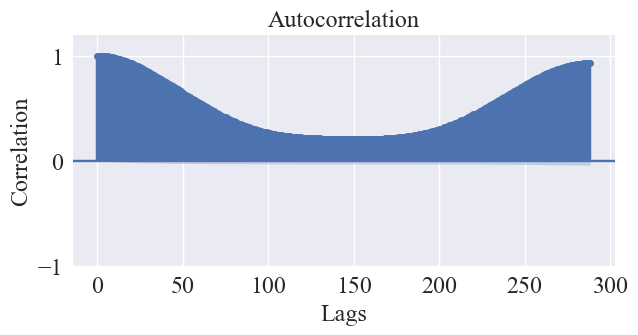

In [12]:
# Autocorrelación 

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Demanda (MW)'], ax=ax, lags=288).savefig('./Plots/Demand_Data_Autocorrelation.svg',bbox_inches='tight')
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.ylim(-1, 1.2)
plt.savefig('./Plots/Demand_Data_Autocorrelation.svg',bbox_inches='tight')
plt.show()

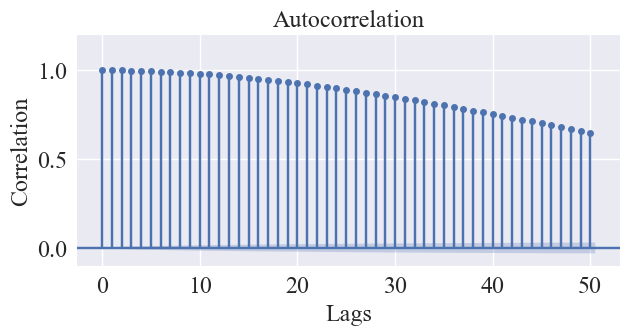

In [13]:
# Autocorrelación with zoom

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(df['Demanda (MW)'], ax=ax, lags=50).savefig('./Plots/Demand_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.ylim(-0.1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/Demand_Data_Autocorrelation_with_zoom.svg',bbox_inches='tight')
plt.show()

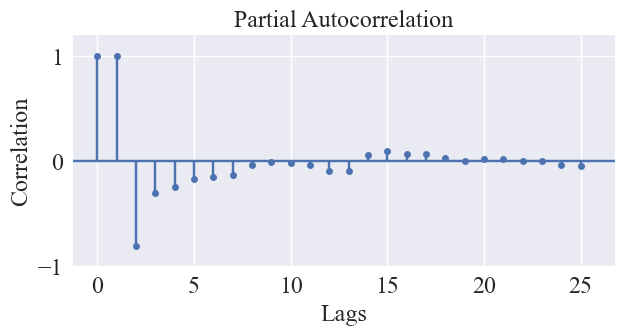

In [14]:
#Autocorrelación Parcial 

fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(df['Demanda (MW)'], ax=ax, lags=25).savefig('./Plots/Demand_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.ylim(-1,1.2)
plt.xlabel("Lags")
plt.ylabel("Correlation")
plt.savefig('./Plots/Demand_Data_Partial_Autocorrelation.svg',bbox_inches='tight')
plt.show()

C:\Users\Jarvis\AppData\Local\Temp\ipykernel_12836\4010934070.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


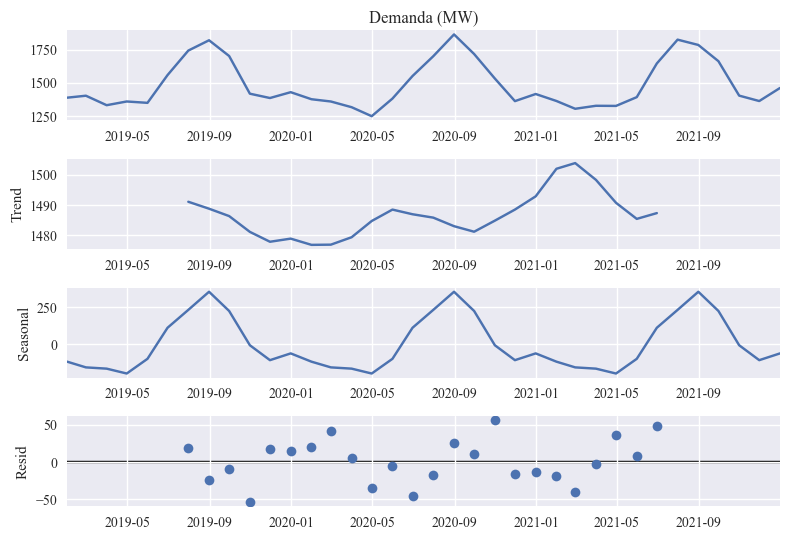

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

datos_ts = df['Demanda (MW)'].resample('M').mean()

# Aplicar el método seasonal_decompose a la serie de tiempo
fig=seasonal_decompose(datos_ts, model='additive').plot()
fig.savefig('./Plots/Demand_Data_Decomposition.svg',bbox_inches='tight')
fig.show()

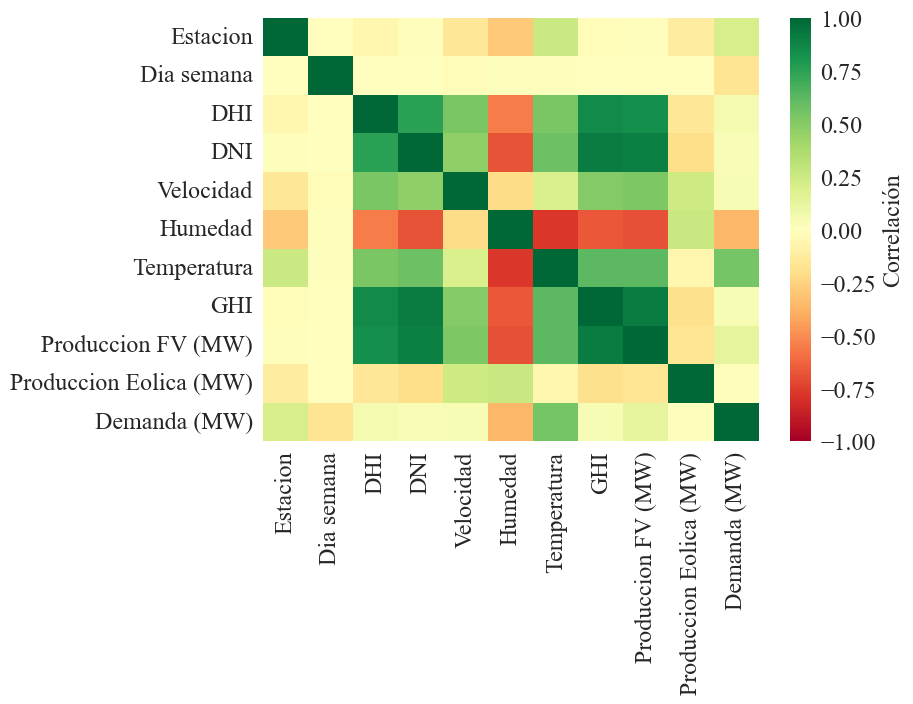

In [6]:
#df2 = pd.DataFrame(data={'Season':df['Estacion'],'Day of the week':df['Dia semana'],'DHI':df['DHI'],'DNI':df['DNI'],'GHI':df['GHI'],'Wind speed':df['Velocidad'],'Humidity':df['Humedad'],'Temperature':df['Temperatura'],'PV production':df['Produccion FV (MW)'],'Wind production':df['Produccion Eolica (MW)']})

corr=df.corr()
sns.heatmap(corr, cmap='RdYlGn',vmin=-1.0, vmax=1.0, cbar_kws={'label': 'Correlación'})
plt.savefig('./Plots/Variable_heatmap.svg',bbox_inches='tight')

In [44]:
# Agregar EDA